# Run a trained model on images and show results

In [1]:
import sys
sys.path.append("../src")

In [2]:
import os
import json

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

from slim_models.nets import resnet_v1
from slim_models.preprocessing import vgg_preprocessing
from models import model_fn
from tools.utils import ImageDecoder

%matplotlib inline

/home/ubuntu/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from six.moves import urllib
import tensorflow as tf

slim = tf.contrib.slim

_NUM_CLASSES = 1001


def create_readable_names_for_imagenet_labels():
  """Create a dict mapping label id to human readable string.

  Returns:
      labels_to_names: dictionary where keys are integers from to 1000
      and values are human-readable names.

  We retrieve a synset file, which contains a list of valid synset labels used
  by ILSVRC competition. There is one synset one per line, eg.
          #   n01440764
          #   n01443537
  We also retrieve a synset_to_human_file, which contains a mapping from synsets
  to human-readable names for every synset in Imagenet. These are stored in a
  tsv format, as follows:
          #   n02119247    black fox
          #   n02119359    silver fox
  We assign each synset (in alphabetical order) an integer, starting from 1
  (since 0 is reserved for the background class).

  Code is based on
  https://github.com/tensorflow/models/blob/master/research/inception/inception/data/build_imagenet_data.py#L463
  """

  # pylint: disable=g-line-too-long
  base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/inception/inception/data/'
  synset_url = '{}/imagenet_lsvrc_2015_synsets.txt'.format(base_url)
  synset_to_human_url = '{}/imagenet_metadata.txt'.format(base_url)

  filename, _ = urllib.request.urlretrieve(synset_url)
  synset_list = [s.strip() for s in open(filename).readlines()]
  num_synsets_in_ilsvrc = len(synset_list)
  assert num_synsets_in_ilsvrc == 1000

  filename, _ = urllib.request.urlretrieve(synset_to_human_url)
  synset_to_human_list = open(filename).readlines()
  num_synsets_in_all_imagenet = len(synset_to_human_list)
  assert num_synsets_in_all_imagenet == 21842

  synset_to_human = {}
  for s in synset_to_human_list:
    parts = s.strip().split('\t')
    assert len(parts) == 2
    synset = parts[0]
    human = parts[1]
    synset_to_human[synset] = human

  label_index = 1
  labels_to_names = {0: 'background'}
  for synset in synset_list:
    name = synset_to_human[synset]
    labels_to_names[label_index] = name
    label_index += 1

  return labels_to_names

labels_to_names = create_readable_names_for_imagenet_labels()

In [4]:
def input_fn(filepaths, visualize=False):
    dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    
    def read_file(filepath):
        image_str = tf.read_file(filepath)
        image_decoded = tf.image.decode_image(image_str, channels=3)
        return image_decoded
    
    def preprocess(image):
        image_size = resnet_v1.resnet_v1_101.default_image_size
        image = vgg_preprocessing.preprocess_image(image, image_size,
                                                   image_size,
                                                   is_training=False)
        if visualize:
            image = vgg_preprocessing._mean_image_subtraction(
                image, [-vgg_preprocessing._R_MEAN, 
                        -vgg_preprocessing._G_MEAN, 
                        -vgg_preprocessing._B_MEAN])
            
        image = tf.expand_dims(image, 0)
        return image
        
    dataset = dataset.map(read_file)
    dataset = dataset.map(preprocess)
    iterator = dataset.make_one_shot_iterator()
    features = {
        "image": iterator.get_next()
    }
    labels = tf.constant(1)
    return features, labels

In [15]:
model_dir = "../pretrained_models/resnet_v1_101/"
params = {
    "num_classes": 1000,
    "network_name": "resnet_v1_101",
    "output_type": "softmax"
}
estimator = tf.estimator.Estimator(model_fn, model_dir=model_dir, params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../pretrained_models/resnet_v1_101/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6a2d5cfc50>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
predict_filepaths = [
#     "/home/ubuntu/github/ai/recycle/data/raw/merged_v2/split/val/re_05_Bottle/empty_plastic_bottles_000186.jpg",
#     "/tmp/original_img/36.jpg",
#     "/tmp/original_img/38.jpg",
#     "/home/ubuntu/Downloads/20171204_155411.jpg",
#     "/home/ubuntu/Downloads/20171204_161156.jpg",
#     "/home/ubuntu/Downloads/20171204_161457.jpg",
#     "/home/ubuntu/Downloads/20171204_161643.jpg",
    "/home/ubuntu/Pictures/recycle/test_whites/spaniel",
    "/home/ubuntu/Pictures/recycle/test_whites/20171208_175920.jpg",
]

predict_filepaths = "/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac"

In [11]:
if isinstance(predict_filepaths, str):
    folder = predict_filepaths
    predict_filepaths = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in filenames:
            predict_filepaths.append(os.path.join(dirpath, filename))
            
    predict_filepaths = sorted(predict_filepaths)
predict_filepaths

['/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075423108.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075427329.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075429660.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075433305.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075435717.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075437642.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075440149.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075445486.jpg',
 '/media/ubuntu/Data/dataset/recycle/real/12_29_2017/done_filter_29_12/images/GiayBac/20171229075448318.jpg',
 '/media/u

In [16]:
exp_predictions = []
for i, pred in enumerate(estimator.predict(
        input_fn=lambda: input_fn(predict_filepaths))):
    class_id = pred['class_id'][0]
    prob = pred['probs'][0]
    exp_predictions.append((labels_to_names[class_id + 1], str(prob[class_id])))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ../pretrained_models/resnet_v1_101/resnet_v1_101.ckpt


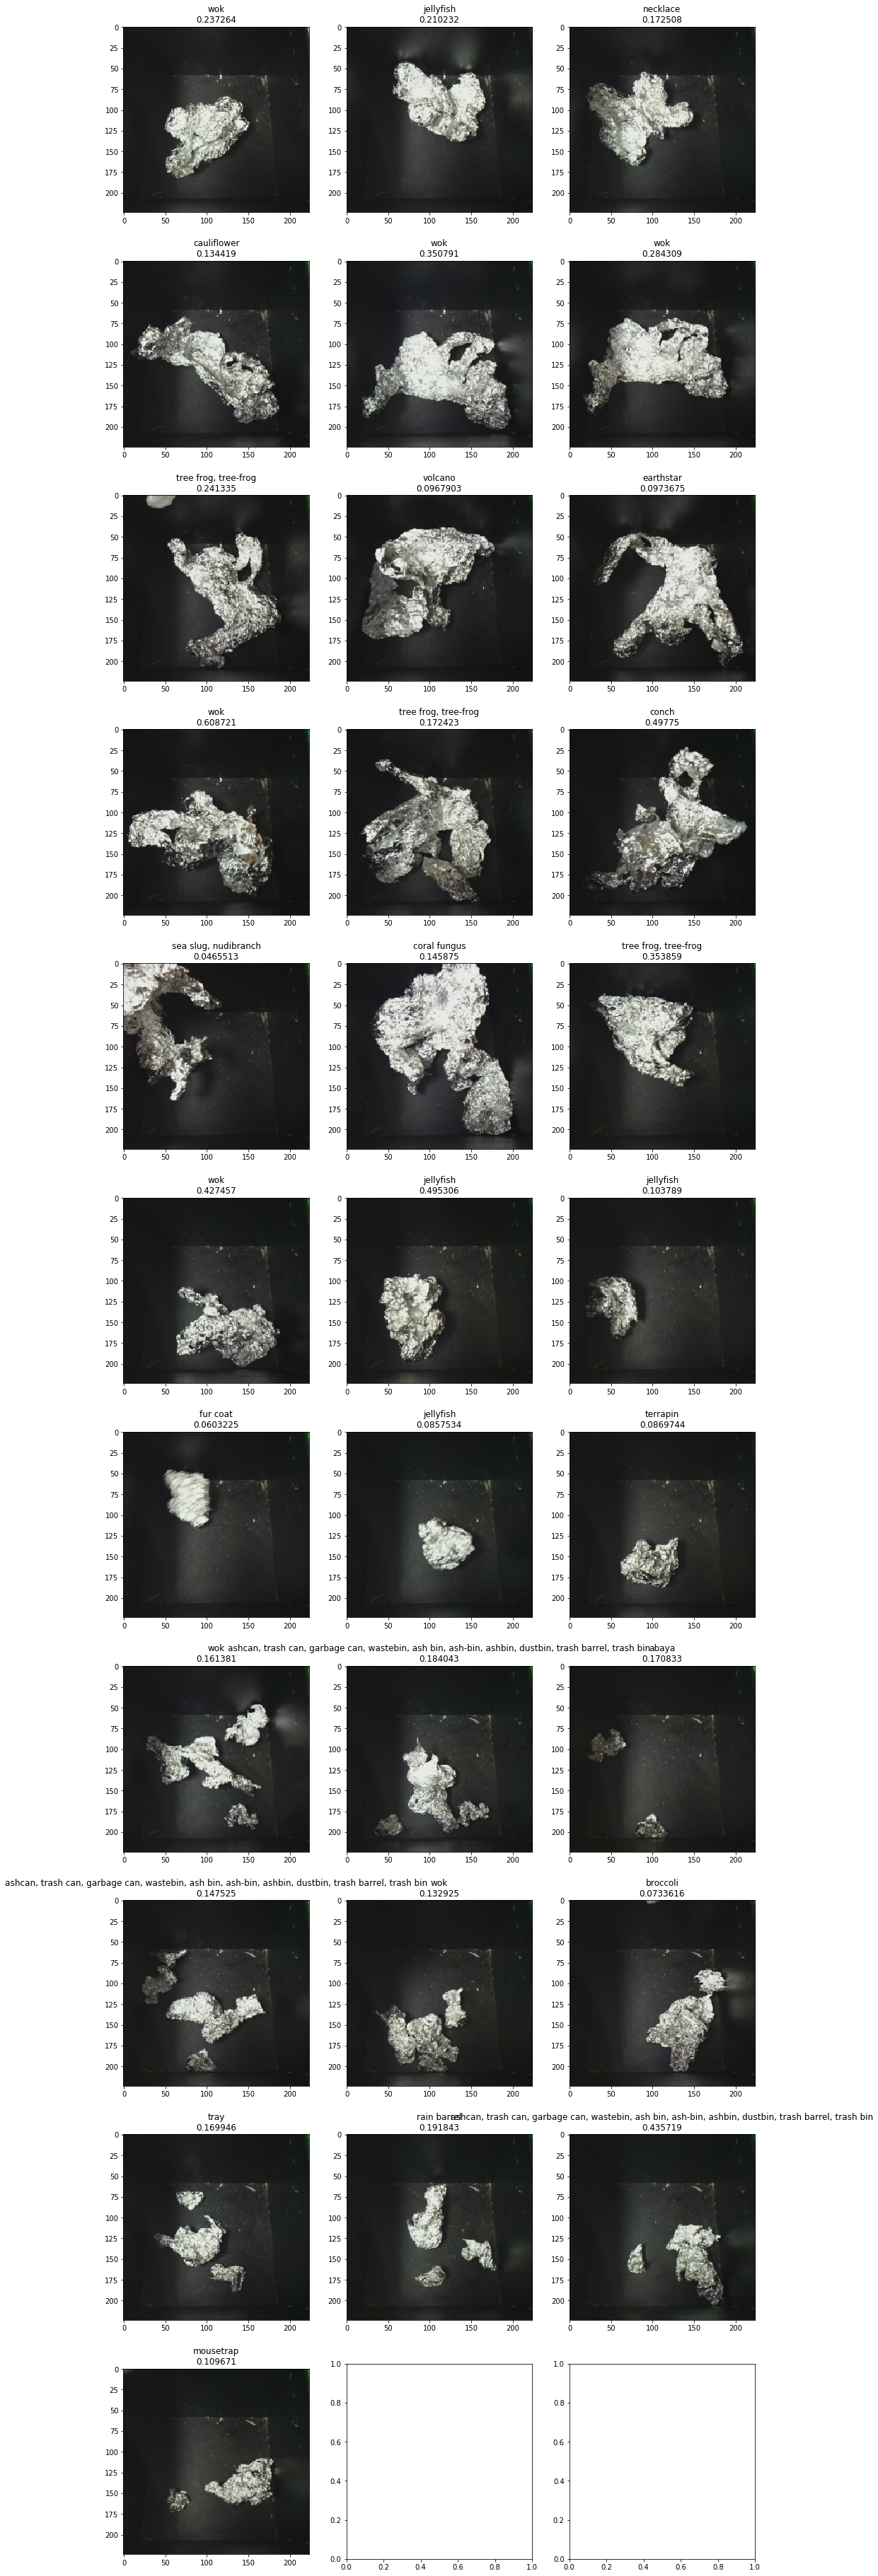

In [17]:
ncols = 3
nrows = len(predict_filepaths) // ncols + 1
fig, axs = plt.subplots(nrows, ncols,
                        figsize=(16, 6 * nrows), squeeze=False)

f, l = input_fn(predict_filepaths, visualize=True)
with tf.Session() as sess:
    try:
        for i, filepath in enumerate(predict_filepaths):
            a, b = sess.run([f, l])
            img = a["image"][0].astype(np.uint8)
            axs[i // ncols][i % ncols].imshow(img)
            axs[i // ncols][i % ncols].set_title(
                exp_predictions[i][0] + "\n" + str(exp_predictions[i][1]))
    except Exception as e:
        pass
